# Run the LNN model

First, we have to create the PyTorch objects out of the NPZ files. NPZ files behave like dictionaries of arrays. In our case, they contain two keys:

- `X`: the featurized systems
- `y`: the associated measurements

We can pass those dict-like arrays to an adapter class for Torch Datasets, which will be ingested by the DataLoaders. We also need the corresponding observation models.

In [1]:
from pathlib import Path
from collections import defaultdict
import numpy as np

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

from kinoml.utils import seed_everything
from kinoml.core import measurements as measurement_types
from kinoml.datasets.torch_datasets import XyNpzTorchDataset

HERE = Path(_dh[-1])
OUT = HERE / "_output/"
OUT.mkdir(parents=True, exist_ok=True)

# Fix the seed for reproducible random splits -- otherwise we get mixed train/test groups every time, biasing the model evaluation
seed_everything()

## Load featurized data and create observation models

In [2]:
datasets = defaultdict(dict)
for npz in HERE.glob("../_output/ChEMBL__*.npz"):
    _, kinase, measurement_type = str(npz.stem).split("__")
    datasets[kinase][measurement_type] = XyNpzTorchDataset(npz)

In [3]:
obs_models = {k: getattr(measurement_types, k).observation_model(backend="pytorch") for k in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]}
obs_models

{'pKiMeasurement': <function kinoml.core.measurements.pKiMeasurement._observation_model_pytorch(dG_over_KT, standard_conc=1, **kwargs)>,
 'pIC50Measurement': <function kinoml.core.measurements.pIC50Measurement._observation_model_pytorch(dG_over_KT, substrate_conc=1e-06, michaelis_constant=1, standard_conc=1, **kwargs)>,
 'pKdMeasurement': <function kinoml.core.measurements.pKdMeasurement._observation_model_pytorch(dG_over_KT, standard_conc=1, **kwargs)>}

Now that we have all the data-dependent objects, we can start with the model-specific definitions.

In [4]:
one_kinase = "P35968"
train_dataloaders, test_dataloaders = {}, {}
for mtype in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]:
    train_dataloaders[mtype], test_dataloaders[mtype] = datasets[one_kinase][mtype].as_dataloader(train_test_split=0.8, shuffle=False, batch_size=64)

## Train the model

In [24]:
from kinoml.ml.torch_models import NeuralNetworkRegression

In [128]:
input_size = train_dataloaders["pIC50Measurement"].dataset.input_size()
model = NeuralNetworkRegression(input_size=input_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_function = torch.nn.MSELoss()  # Mean squared error

model, loss_timeseries = multi_measurement_training_loop(
        dataloaders = train_dataloaders,
        observation_models=obs_models,
        model=model, 
        optimizer=optimizer,
        loss_function=loss_function,
        epochs=100
)

Save model to disk!

In [7]:
torch.save(model, OUT / "model.pt")

## Analysis

Load model back if it was not trained in the same session:

In [12]:
try: 
    model = model
except NameError:
    model = torch.load(OUT / "model.pt")

Loss  timeseries

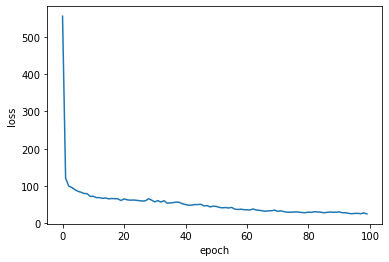

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

f = plt.figure()
plt.plot(loss_timeseries)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Measure performance against all data

In [125]:
from kinoml.analysis.plots import predicted_vs_observed

pKiMeasurement train
--------------------
 MAE: 0.45±0.03 95CI=(0.41, 0.52)
 MSE: 0.39±0.08 95CI=(0.28, 0.56)
  R2: 0.83±0.03 95CI=(0.77, 0.88)
RMSE: 0.62±0.07 95CI=(0.53, 0.75)


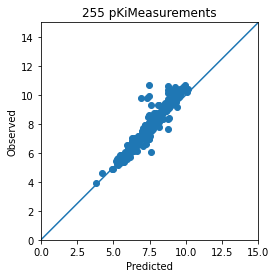

pKiMeasurement test
-------------------
 MAE: 0.69±0.09 95CI=(0.54, 0.84)
 MSE: 0.85±0.22 95CI=(0.50, 1.23)
  R2: 0.52±0.13 95CI=(0.31, 0.70)
RMSE: 0.92±0.12 95CI=(0.71, 1.11)


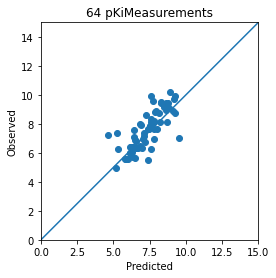


****************
pIC50Measurement train
----------------------
 MAE: 0.28±0.00 95CI=(0.27, 0.29)
 MSE: 0.17±0.01 95CI=(0.16, 0.18)
  R2: 0.87±0.00 95CI=(0.86, 0.88)
RMSE: 0.41±0.01 95CI=(0.40, 0.43)


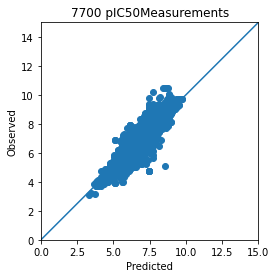

pIC50Measurement test
---------------------
 MAE: 0.59±0.01 95CI=(0.56, 0.61)
 MSE: 0.62±0.03 95CI=(0.57, 0.67)
  R2: 0.51±0.03 95CI=(0.47, 0.55)
RMSE: 0.79±0.02 95CI=(0.76, 0.82)


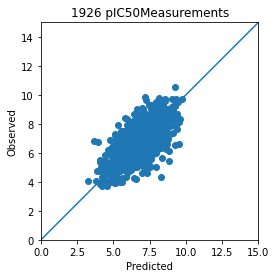


****************
pKdMeasurement train
--------------------
 MAE: 0.35±0.06 95CI=(0.24, 0.44)
 MSE: 0.35±0.11 95CI=(0.16, 0.53)
  R2: 0.73±0.07 95CI=(0.63, 0.83)
RMSE: 0.58±0.10 95CI=(0.40, 0.73)


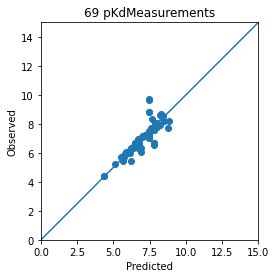

pKdMeasurement test
-------------------
 MAE: 0.66±0.20 95CI=(0.35, 1.04)
 MSE: 0.96±0.49 95CI=(0.34, 1.86)
  R2: 0.36±0.30 95CI=(-0.18, 0.74)
RMSE: 0.95±0.25 95CI=(0.58, 1.36)


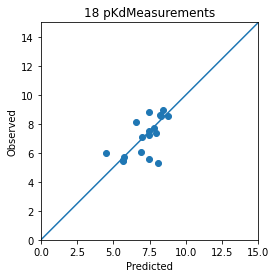


****************


In [126]:
for mtype in ["pKiMeasurement", "pIC50Measurement", "pKdMeasurement"]:
    for ttype, dataloaders in {"train": train_dataloaders, "test": test_dataloaders}.items():
        observed = dataloaders[mtype].dataset.data_y[dataloaders[mtype].sampler.indices]
        model_input = dataloaders[mtype].dataset.data_X[dataloaders[mtype].sampler.indices]

        delta_g = model(model_input)
        prediction = obs_models[mtype](delta_g).detach().numpy()

        print(mtype, ttype)
        print("-"*(len(mtype)+len(ttype)+1))
        display(predicted_vs_observed(prediction, observed, limits=(0, 15), title=f"{prediction.shape[0]} {mtype}s", n_boot=100, sample_ratio=0.75))
    print("\n****************")

In [4]:
from kinoml.utils import watermark
watermark()

Watermark
---------
torch  1.6.0
kinoml 0+untagged.193.gcb027c6.dirty
numpy  1.19.1
last updated: 2020-10-01 13:11:58 CEST 2020-10-01T13:11:58+02:00

CPython 3.7.8
IPython 7.17.0

compiler   : GCC 7.5.0
system     : Linux
release    : 4.19.128-microsoft-standard
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
host name  : jrodriguez
Git hash   : e9f2eb53a3b22056c73920f81f77e572e1a4d187
watermark 2.0.2

conda
-----
sys.version: 3.7.6 | packaged by conda-forge | (defau...
sys.prefix: /opt/miniconda
sys.executable: /opt/miniconda/bin/python
conda location: /opt/miniconda/lib/python3.7/site-packages/conda
conda-build: /opt/miniconda/bin/conda-build
conda-convert: /opt/miniconda/bin/conda-convert
conda-debug: /opt/miniconda/bin/conda-debug
conda-develop: /opt/miniconda/bin/conda-develop
conda-env: /opt/miniconda/bin/conda-env
conda-index: /opt/miniconda/bin/conda-index
conda-inspect: /opt/miniconda/bin/conda-inspect
conda-metapackage: /opt/miniconda/bin/conda-metap